## Configure PUDL
The `.pudl.yml` configuration file tells PUDL where to look for data. Uncomment the next cell and run it if you're on our 2i2c JupyterHub.

In [1]:
#!cp ~/shared/shared-pudl.yml ~/.pudl.yml

# An Introduction to Working with EPA CEMS data

CEMS or <a href='https://www.epa.gov/emc/emc-continuous-emission-monitoring-systems'>**Continusous Emissions Monitoring Systems**</a> are used to track power plant's compliance with EPA emission standards. Among the data are hourly measurements of SO2, CO2, and NOx emissions associated with a given plant. The EPA's <a href='https://www.epa.gov/airmarkets'>Clean Air Markets Division</a> has collected CEMS data stretching back to 1990 and publicized it in their <a href='https://ampd.epa.gov/ampd/'>data portal</a>. Combinging the CEMS data with EIA and FERC data provides access to greater and more specific information about utilities and generation facilities. This notebook provides a glimpse into the analysis potential of CEMS data usage and integration.

**NOTE**: This Notebook presuposes access to the parquet files in which the CEMS data is stored.

# PUDL Notebook Setup

The following packages enable interaction with the CEMS dataset through pudl.

In [2]:
%load_ext autoreload
%autoreload 3

In [3]:
# Standard libraries
import logging
from pathlib import Path
import os
import sys

# 3rd party libraries
import intake
import pandas as pd
import sqlalchemy as sa

# Local libraries
import pudl
import pudl_catalog
from pudl_catalog.helpers import year_state_filter

In [4]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
#display(pudl_settings)

ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
#display(ferc1_engine)

pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
#display(pudl_engine)

#pudl_engine.table_names()
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine, freq='AS') #annual frequency

# Bigger Data with Dask, Parquet, and Intake

* The EPA CEMS hourly dataset is enormous! It contains hourly operations and emissions data for thousands of power plants between 1995 and 2020.
* The full dataset is close to a billion rows and takes up 100 GB of space uncompressed, which means it will not all fit in memory on your laptop at the same time.
* To work with kind of data conveniently we need some new tools beyond CSV files and pandas.

## Dask dataframes: Pandas for bigger data

* One of the best tools for dealing with larger-than-memory data analysis in Python is **[Dask](https://dask.org)**.
* Dask extends Pandas but maintains a similiar interface. We'll be using some of Dask's features below to work with this larger dataset.
* One of the main features of Dask is "lazy execution" -- it doesn't read data or do any computation until it has to, or you explicitly tell it to.
* First you construct a set of a series of computational instructions.
* Then Dask intelligently looks at those instructions and executes them so as to minimize memory utilization and/or parallelize the tasks if possible.

### Additional Dask Resources:
* **[Scaling Pandas](https://tomaugspurger.github.io/modern-8-scaling.html)** is a brief introduction to the ideas behind Dask, from 2018.
* **[How to learn Dask in 2021](https://coiled.io/blog/how-to-learn-dask-in-2021/)** is a more extensive and up-to-date self-guided tutorial.

## Apache Parquet

* We store the EPA CEMS data in **[Apache Parquet files](https://parquet.apache.org/)**, which enable fast distributed access to tabular data.
* We have partitioned the EPA CEMS hourly data by `year` and `state`, to make it easier to read in only the chunks you need.
* This means that inside the Parquet files, any combination of `year` and `state` can be individually addressed, without scanning all the other records.

## Intake Data Catalogs

* We've built a data catalog using the Intake library.
* The catalog tracks the version, metadata, and storage location of the data it contains.
* It can also do local file caching to avoid repeatedly downloading the same data.
* The EPA CEMS hourly emissions data is the first dataset we've added to the catalog.
* Below we'll primarily use this catalog to access the CEMS data.
* See **[The PUDL Data Catalog](https://github.com/catalyst-cooperative/pudl-catalog)** for more information.

# Accessing EPA CEMS with the PUDL Catalog

* By default, the PUDL Catalog reads data from Google Cloud Storage over the network.
* The catalog can also be told to look at a local copy of the data if it's available.
* If you want to use local file caching, you need to tell Intake where to store the cache.
* If you already have the data locally, file caching isn't necessary, and will slow things down and take up disk space.
* We have a local copy of the data stored on the 2i2c JupyterHub
* You tell the catalog where to find the data, and where to store the local cache by setting two environment variables.
* `PUDL_INTAKE_PATH` should point at the main directory containing all the data
* `PUDL_INTAKE_CACHE` should point at the directory where you want downloaded data to be cached locally.

## Configure catalog paths

In [7]:
# Local data storage for use on our 2i2c JupyterHub
os.environ["PUDL_INTAKE_PATH"] = str(Path.home() / "shared/intake.catalyst.coop/v0.1.0")
CACHE_METHOD = ""

# Remote data storage if you're working on your own computer:
#os.environ["PUDL_INTAKE_PATH"] = "gs://intake.catalyst.coop/v0.1.0"
#CACHE_METHOD = "simplecache::"

# Default local file cache location.
# Note: file is stored locally on the JupyterHub already, so there's no reason
# to cache files -- make sure you use cache_method="" when pulling data.
os.environ["PUDL_INTAKE_CACHE"] = str(Path.home() / ".intake/cache")

# This reads the PUDL catalog metadata from the top-level Intake catalog:
pudl_cat = intake.cat["pudl_cat"]

# Print out some information just to make sure we've got things right:
print(f"{pudl_catalog.__version__=}")
print(f"{os.getenv('PUDL_INTAKE_PATH')=}")
print(f"{os.getenv('PUDL_INTAKE_CACHE')=}")

pudl_catalog.__version__='0.1.0'
os.getenv('PUDL_INTAKE_PATH')='gs://intake.catalyst.coop/v0.1.0'
os.getenv('PUDL_INTAKE_CACHE')='/home/zane/.intake/cache'


## Inspect the PUDL Catalog metadata

In [8]:
pudl_cat

pudl_cat:
  args:
    path: /home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/pudl_catalog/pudl_catalog.yaml
  description: A catalog of open energy system data for use by climate advocates,
    policymakers, journalists, researchers, and other members of civil society.
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    creator:
      email: pudl@catalyst.coop
      path: https://catalyst.coop
      title: Catalyst Cooperative
    parameters:
      cache_method:
        allowed:
        - 'simplecache::'
        - ''
        default: 'simplecache::'
        description: Whether to cache data locally; empty string to disable caching.
        type: str


## List the PUDL Catalog data sources
* This shows you the names of the data sources in the catalog
* Each of them in turn have their own metadata
* We'll use the `hourly_emissions_epacems` data source.

In [9]:
list(pudl_cat)

['hourly_emissions_epacems', 'hourly_emissions_epacems_partitioned']

## Inspect the EPA CEMS data source 

In [10]:
pudl_cat.hourly_emissions_epacems()

hourly_emissions_epacems:
  args:
    engine: pyarrow
    storage_options:
      simplecache:
        cache_storage: /home/zane/.intake/cache
      token: anon
    urlpath: simplecache::gs://intake.catalyst.coop/v0.1.0/hourly_emissions_epacems.parquet
  description: Hourly pollution emissions and plant operational data reported via
    Continuous Emissions Monitoring Systems (CEMS) as required by 40 CFR Part 75.
    Includes CO2, NOx, and SO2, as well as the heat content of fuel consumed and gross
    power output. Hourly values reported by US EIA ORISPL code and emissions unit
    (smokestack) ID.
  driver: intake_parquet.source.ParquetSource
  metadata:
    catalog_dir: /home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/pudl_catalog/
    license:
      name: CC-BY-4.0
      path: https://creativecommons.org/licenses/by/4.0
      title: Creative Commons Attribution 4.0
    path: https://ampd.epa.gov/ampd
    provider: US Environmental Protection Agency Air Markets Progra

## Disabling file caching for local data
* Caching is enabled by default, since typically users are accessing remote data.
* If you call the data source with `cache_method` set to the empty string, caching will be disabled.
* This is preferable for local data access. Note the difference between the `urlpath` above and below

In [11]:
pudl_cat.hourly_emissions_epacems(cache_method=CACHE_METHOD)

hourly_emissions_epacems:
  args:
    engine: pyarrow
    storage_options:
      simplecache:
        cache_storage: /home/zane/.intake/cache
      token: anon
    urlpath: simplecache::gs://intake.catalyst.coop/v0.1.0/hourly_emissions_epacems.parquet
  description: Hourly pollution emissions and plant operational data reported via
    Continuous Emissions Monitoring Systems (CEMS) as required by 40 CFR Part 75.
    Includes CO2, NOx, and SO2, as well as the heat content of fuel consumed and gross
    power output. Hourly values reported by US EIA ORISPL code and emissions unit
    (smokestack) ID.
  driver: intake_parquet.source.ParquetSource
  metadata:
    catalog_dir: /home/zane/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/pudl_catalog/
    license:
      name: CC-BY-4.0
      path: https://creativecommons.org/licenses/by/4.0
      title: Creative Commons Attribution 4.0
    path: https://ampd.epa.gov/ampd
    provider: US Environmental Protection Agency Air Markets Progra

## Requesting a Dask dataframe
* You can ask the data source to return a Dask dataframe using the `to_dask()` method.
* Note that because of lazy execution, the dataframe won't have any data in it yet.
* However, because of the metadata available in the Parquet files the column names and data types are available.
* Right now we don't have column-level metadata embedded in the catalog, but you can read more about the data set in our [EPA CEMS data source documentation](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/epacems.html) and the [Hourly Emissions EPA CEMS data dictionary entry](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#hourly-emissions-epacems).

In [12]:
%%time
epacems_dd = pudl_cat.hourly_emissions_epacems(
    cache_method=CACHE_METHOD,
).to_dask()

CPU times: user 405 ms, sys: 36.8 ms, total: 441 ms
Wall time: 878 ms


In [13]:
epacems_dd

,plant_id_eia,unitid,operating_datetime_utc,year,state,facility_id,unit_id_epa,operating_time_hours,gross_load_mw,heat_content_mmbtu,steam_load_1000_lbs,so2_mass_lbs,so2_mass_measurement_code,nox_rate_lbs_mmbtu,nox_rate_measurement_code,nox_mass_lbs,nox_mass_measurement_code,co2_mass_tons,co2_mass_measurement_code
npartitions=1,,,,,,,,,,,,,,,,,,,
,int32,object,"datetime64[ns, UTC]",int32,int64,int32,object,float32,float32,float32,float32,float32,int64,float32,int64,float32,int64,float32,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Analyzing a Subset of EPA CEMS Data

* One strategy for working with a large dataset is to only look at small subsets of it in any given analysis.
* You can point Dask at a large parquet dataset like EPA CEMS and tell it to read in only a subset of the columns, and the select a subset of the rows based on some criteria of interest.
* So long as the collection of rows and columns you've specified end up being smaller than the available memory on you computer, this operation will succeed.

## Filter using Parquet partitions

* As mentioned above, the EPA CEMS data is partitioned into "row groups" each of which contain a single year-state combination.
* The location of each row groups can be looked up quickly in the Parquet metadata without needing to process the data itself.
* This means filtering the data on the basis of these special columns can be much more efficient.
* Filters have to be specified using a nested list of lists of boolean predicates (known as [disjunctive normal form](https://en.wikipedia.org/wiki/Disjunctive_normal_form).
* DNF is a little unwieldy, and typically you'll want some set of years for some set of states, with all combinations of states
  and years, so we have a shortcut function that will build the DNF filters for you: `pudl_catalog.helpers.year_state_filter()`

In [14]:
# Filter for selectin CO & WY data for 2019 & 2020:
year_state_filter(years=[2019, 2020], states=["CO", "WY"])

[[('year', '=', 2019), ('state', '=', 'CO')],
 [('year', '=', 2019), ('state', '=', 'WY')],
 [('year', '=', 2020), ('state', '=', 'CO')],
 [('year', '=', 2020), ('state', '=', 'WY')]]

In [15]:
epacems_dd = pudl_cat.hourly_emissions_epacems(
    cache_method=CACHE_METHOD,
    filters=year_state_filter(years=[2020], states=["CO"]),
).to_dask()

### How much data is there now?
* After filtering for 1 year of CO data, we only have 600k instead of 800M rows.
* This is small enough that we can actually load it into memory in a normal pandas dataframe

In [16]:
len(epacems_dd)

601632

### From Dask to Pandas
* The goal is generally to get down to a managable amount of data by filtering or aggregating.
* Once you're confident that the data you're selecting will fit in memory, you can call `dd.compute()` to turn the Dask dataframe into a Pandas dataframe.

In [17]:
epacems_df = epacems_dd.compute()
epacems_df.sample(10)

,plant_id_eia,unitid,operating_datetime_utc,year,state,facility_id,unit_id_epa,operating_time_hours,gross_load_mw,heat_content_mmbtu,steam_load_1000_lbs,so2_mass_lbs,so2_mass_measurement_code,nox_rate_lbs_mmbtu,nox_rate_measurement_code,nox_mass_lbs,nox_mass_measurement_code,co2_mass_tons,co2_mass_measurement_code
44941,55835,2,2020-01-13 20:00:00+00:00,2020,CO,7584,10174,1.0,273.0,2113.000000,NaN,1.268000,Measured,0.010,Measured,21.129999,Calculated,125.599998,Measured
520588,6761,D,2020-11-21 11:00:00+00:00,2020,CO,875,89476,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54140,469,6,2020-02-29 03:00:00+00:00,2020,CO,79,90851,1.0,185.0,1262.000000,NaN,0.800000,Measured,0.012,Measured,15.144000,Calculated,75.000000,Measured
143337,55645,CT-01,2020-03-06 16:00:00+00:00,2020,CO,7249,8706,1.0,142.0,1527.500000,NaN,0.917000,Measured,0.030,Measured,45.825001,Calculated,90.800003,Measured
155357,470,1,2020-04-14 12:00:00+00:00,2020,CO,80,299,1.0,342.0,3198.399902,NaN,235.100006,Measured,0.119,Measured,380.609985,Calculated,325.799988,Measured
522310,8219,2,2020-11-03 05:00:00+00:00,2020,CO,1074,3467,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159345,478,3,2020-04-30 16:00:00+00:00,2020,CO,82,312,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520922,6761,F,2020-11-05 09:00:00+00:00,2020,CO,875,90256,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38554,55453,5,2020-01-26 17:00:00+00:00,2020,CO,1493,4794,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153159,469,4,2020-04-12 22:00:00+00:00,2020,CO,79,298,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Select only some columns
* Often you will only be interested in a certain subset of the columns stored in a parquet dataset.
* Parquet files are organized internally to make it very efficient to only select certain columns.
* The data source has a few of its own special arguments (like `cache_method`) but most arguments are passed through to `dask.dataframe.read_parquet()`
* You can specify the columns with the `columns` keyword argument to select only some columns.
* Say you're only interested in power outputs, fuel consumed, and CO2 emissions, but not traditional air pollutants:

In [18]:
%%time
ghg_cols = [
    "operating_datetime_utc",
    "plant_id_eia",
    "unitid",
    "facility_id",
    "unit_id_epa",
    "operating_time_hours",
    "gross_load_mw",
    "heat_content_mmbtu",
    "co2_mass_tons",
]
epacems_dd = pudl_cat.hourly_emissions_epacems(
    cache_method=CACHE_METHOD,
    filters=year_state_filter(years=[2020], states=["CO"]),
    columns=ghg_cols,
).to_dask()
epacems_df = epacems_dd.compute()
epacems_df.sample(10)

CPU times: user 499 ms, sys: 118 ms, total: 618 ms
Wall time: 1.18 s


,operating_datetime_utc,plant_id_eia,unitid,facility_id,unit_id_epa,operating_time_hours,gross_load_mw,heat_content_mmbtu,co2_mass_tons
419278,2020-09-07 05:00:00+00:00,6761,101,875,2906,1.0,298.0,2813.000000,295.000000
390252,2020-08-18 19:00:00+00:00,55453,3,1493,4792,1.0,17.0,218.100006,13.000000
123328,2020-03-09 23:00:00+00:00,8219,3,1074,3468,0.0,0.0,0.000000,NaN
465271,2020-10-18 14:00:00+00:00,6112,4,821,2781,0.0,0.0,0.000000,NaN
205780,2020-05-12 11:00:00+00:00,470,1,80,299,0.0,0.0,0.000000,NaN
55034,2020-02-08 09:00:00+00:00,470,2,80,300,1.0,190.0,2067.899902,216.899994
330211,2020-07-28 02:00:00+00:00,50707,S002,8291,90506,1.0,36.0,289.799988,17.200001
512109,2020-11-28 04:00:00+00:00,6021,C2,789,2685,1.0,319.0,3435.199951,360.299988
431408,2020-09-02 15:00:00+00:00,55127,CT1,1286,3958,0.0,0.0,0.000000,NaN
263100,2020-06-23 19:00:00+00:00,492,7,83,315,0.0,0.0,0.000000,NaN


## Combining these selection tools
We can combine these methods to select a small subset of the large dataset very quickly. Let's just load data related to Xcel Energy's Comanche coal plant in Colorado. Since the EPA CEMS data only contains the EIA Plant ID, we need to look that up first.

In [19]:
comanche_colorado = (
    pudl_out.plants_eia860()
    .query("plant_name_eia=='Comanche'")
    .loc[:,["report_date", "plant_id_eia", "plant_name_eia", "utility_id_eia", "city", "state"]]
    .merge(pudl_out.utils_eia860()[["utility_id_eia", "utility_name_eia", "report_date"]])
)
comanche_colorado

,report_date,plant_id_eia,plant_name_eia,utility_id_eia,city,state,utility_name_eia
0,2001-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
1,2002-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
2,2003-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
3,2004-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
4,2005-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
5,2006-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
6,2007-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
7,2008-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
8,2009-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
9,2010-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado


Based on the above, we can see that Comanche has `plant_id_eia == 470` and we already know that it's in Colorado. So let's load all the years of data from Colorado, but only for Comanche, and calculate these additional values
* Gross Generation (MWh)
* Heat Rate (mmBTU / MWh)
* Gross CO2 intensity (tons / MWh)

In [20]:
%%time
comanche_dd = (
    pudl_cat.hourly_emissions_epacems(
        cache_method=CACHE_METHOD,
        filters=year_state_filter(states=["CO"]),  # No years means all years
        columns=ghg_cols,
    )
    .to_dask()
    .query("plant_id_eia==470")
)
comanche_df = (
    comanche_dd.compute()
    .assign(
        gross_generation_mwh=lambda x: x.operating_time_hours * x.gross_load_mw,
        heat_rate_mmbtu_mwh=lambda x: x.heat_content_mmbtu / x.gross_generation_mwh,
        gross_co2_intensity=lambda x: x.co2_mass_tons / x.gross_generation_mwh
    )
)
comanche_df.sample(10)

CPU times: user 2.88 s, sys: 910 ms, total: 3.79 s
Wall time: 3.4 s


,operating_datetime_utc,plant_id_eia,unitid,facility_id,unit_id_epa,operating_time_hours,gross_load_mw,heat_content_mmbtu,co2_mass_tons,gross_generation_mwh,heat_rate_mmbtu_mwh,gross_co2_intensity
7419751,2013-01-10 14:00:00+00:00,470,3,80.0,89734,1.0,639.0,5893.399902,618.099976,639.0,9.222848,0.967293
6156684,2011-01-16 19:00:00+00:00,470,1,80.0,299,1.0,299.0,2735.500000,286.899994,299.0,9.148829,0.959532
10620942,2018-01-31 13:00:00+00:00,470,3,80.0,89734,1.0,796.0,7169.799805,752.000000,796.0,9.007286,0.944724
6823856,2012-02-14 15:00:00+00:00,470,2,80.0,300,1.0,353.0,3723.300049,390.500000,353.0,10.547592,1.106232
6823999,2012-02-20 14:00:00+00:00,470,2,80.0,300,1.0,265.0,2730.199951,286.299988,265.0,10.302641,1.080377
5897277,2010-08-09 04:00:00+00:00,470,2,80.0,300,1.0,335.0,3231.699951,338.899994,335.0,9.646866,1.011642
1866252,2003-01-21 19:00:00+00:00,470,1,NaN,None,1.0,245.0,2731.000000,280.200012,245.0,11.146938,1.143674
3202238,2005-09-18 21:00:00+00:00,470,2,NaN,None,0.0,0.0,0.000000,NaN,0.0,NaN,NaN
10981852,2018-08-17 11:00:00+00:00,470,3,80.0,89734,1.0,802.0,6907.299805,724.400024,802.0,8.612594,0.903242
1941489,2003-03-29 16:00:00+00:00,470,1,NaN,None,1.0,290.0,3071.000000,315.100006,290.0,10.589655,1.086552


This has selected almost 500,000 rows and 50 MB of data out of ~1 billion rows and ~100 GB in a few seconds:

In [21]:
comanche_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517200 entries, 6696 to 12416663
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   operating_datetime_utc  517200 non-null  datetime64[ns, UTC]
 1   plant_id_eia            517200 non-null  int32              
 2   unitid                  517200 non-null  object             
 3   facility_id             355392 non-null  float64            
 4   unit_id_epa             355392 non-null  object             
 5   operating_time_hours    516916 non-null  float32            
 6   gross_load_mw           517200 non-null  float32            
 7   heat_content_mmbtu      517200 non-null  float32            
 8   co2_mass_tons           443448 non-null  float32            
 9   gross_generation_mwh    516916 non-null  float32            
 10  heat_rate_mmbtu_mwh     443436 non-null  float32            
 11  gross_co2_intensity  

## Visualizing Plant Operations Through Time
Now that we've got a managable dataframe, we can visualize what's inside it! Here's the heat content of the fuel consumed each hour for the last 25 years in the three Comanche coal units.

### Fuel Consumption

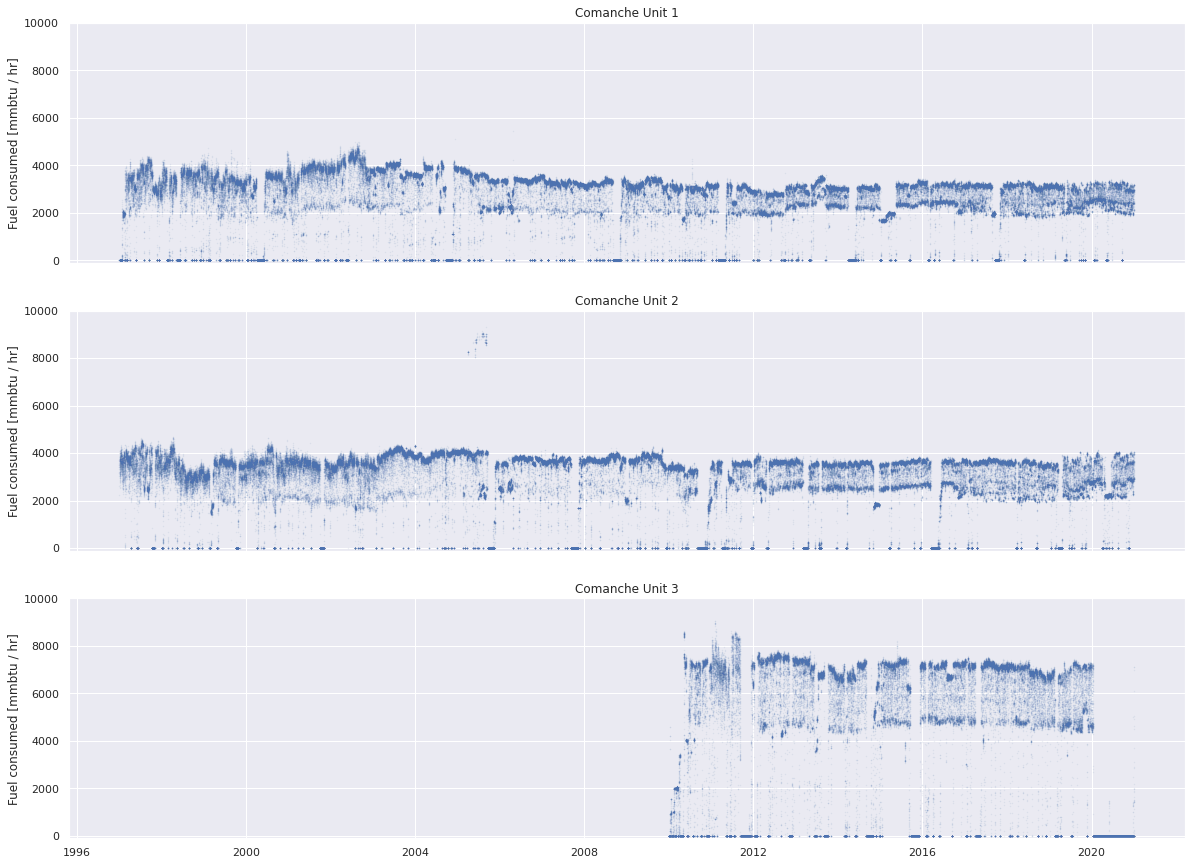

In [22]:
unit_ids = comanche_df.unitid.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unitid in enumerate(comanche_df.unitid.unique()):
    axs[n].scatter(
        comanche_df.query("unitid==@unitid").operating_datetime_utc,
        comanche_df.query("unitid==@unitid").heat_content_mmbtu,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,10_000)
    axs[n].set_title(f"Comanche Unit {unitid}")
    axs[n].set_ylabel("Fuel consumed [mmbtu / hr]")
plt.show();

### Heat Rate

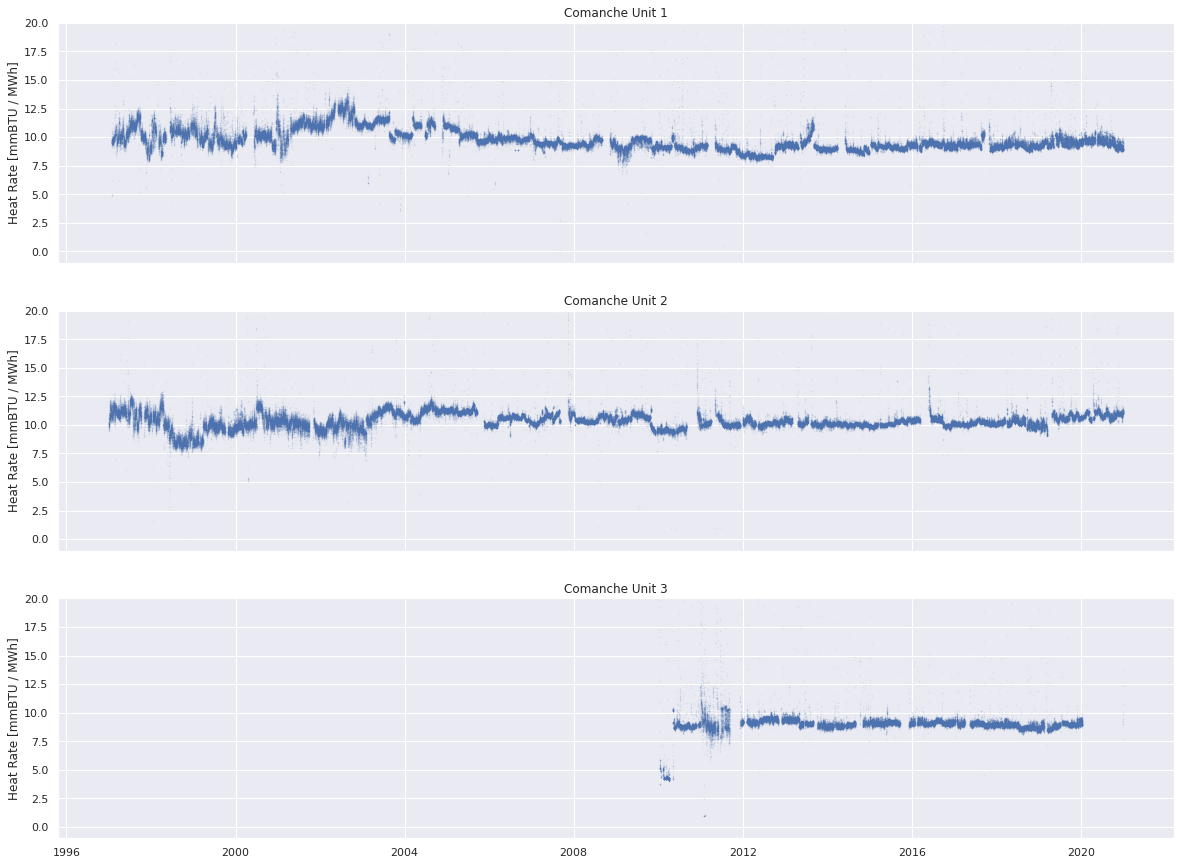

In [23]:
unit_ids = comanche_df.unitid.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unitid in enumerate(comanche_df.unitid.unique()):
    axs[n].scatter(
        comanche_df.query("unitid==@unitid").operating_datetime_utc,
        comanche_df.query("unitid==@unitid").heat_rate_mmbtu_mwh,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-1,20)
    axs[n].set_title(f"Comanche Unit {unitid}")
    axs[n].set_ylabel("Heat Rate [mmBTU / MWh]")
plt.show();

### Carbon Intensity

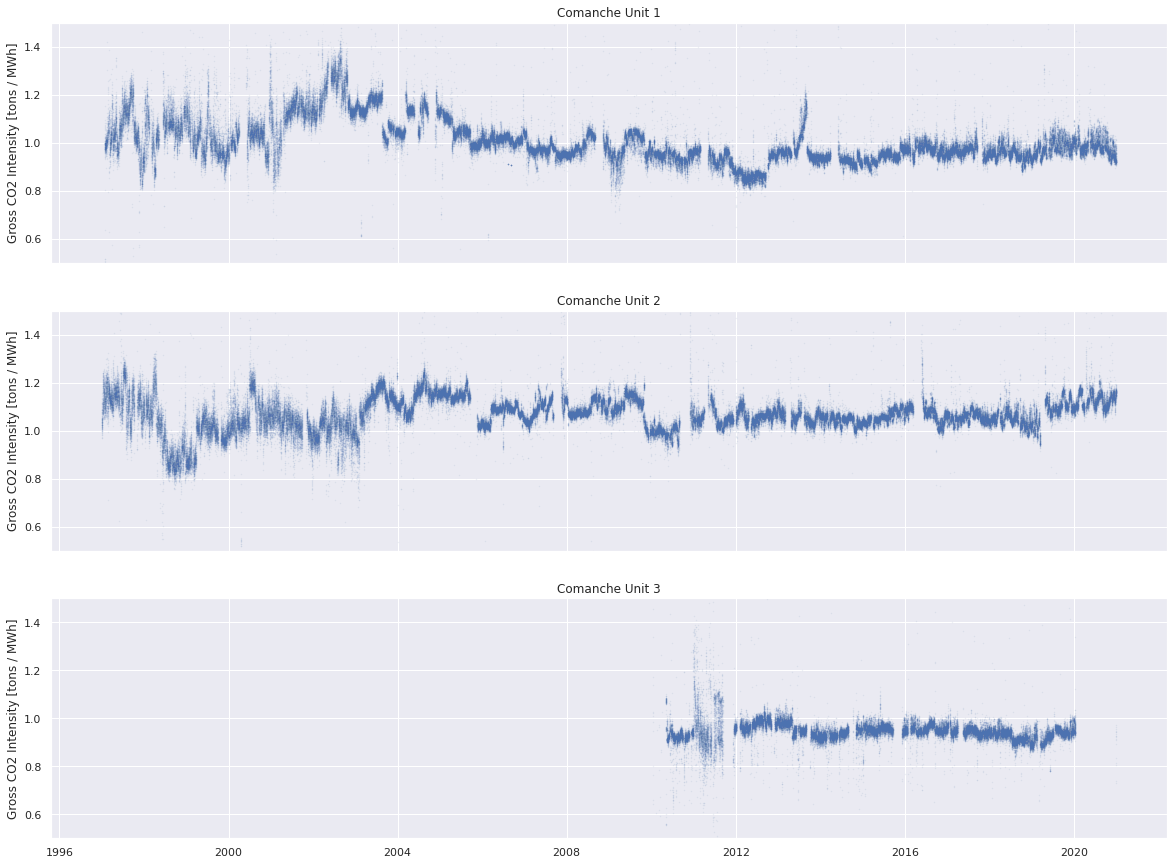

In [24]:
unit_ids = comanche_df.unitid.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unitid in enumerate(comanche_df.unitid.unique()):
    axs[n].scatter(
        comanche_df.query("unitid==@unitid").operating_datetime_utc,
        comanche_df.query("unitid==@unitid").gross_co2_intensity,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(0.5,1.5)
    axs[n].set_title(f"Comanche Unit {unitid}")
    axs[n].set_ylabel("Gross CO2 Intensity [tons / MWh]")
plt.show();

### Gross Load

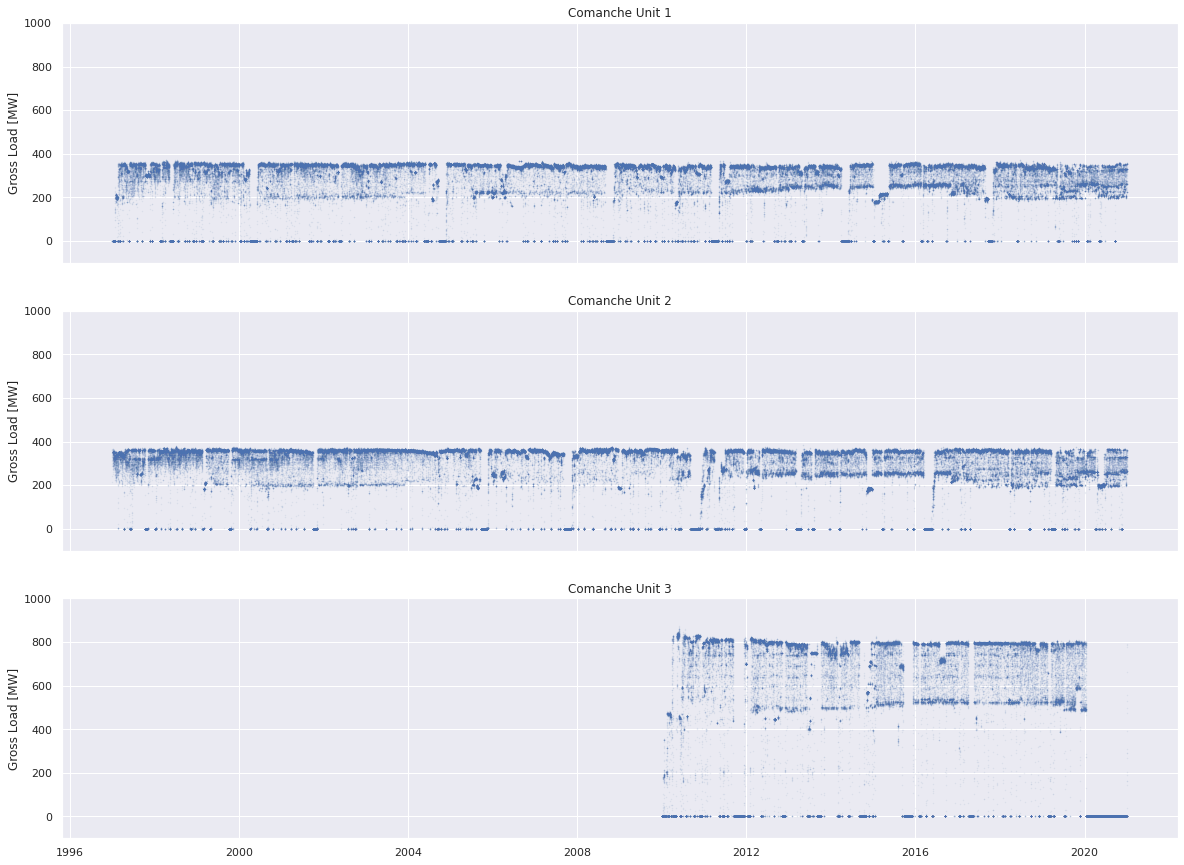

In [25]:
unit_ids = comanche_df.unitid.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unitid in enumerate(comanche_df.unitid.unique()):
    axs[n].scatter(
        comanche_df.query("unitid==@unitid").operating_datetime_utc,
        comanche_df.query("unitid==@unitid").gross_load_mw,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,1000)
    axs[n].set_title(f"Comanche Unit {unitid}")
    axs[n].set_ylabel("Gross Load [MW]")
plt.show();